In [5]:
from src.agents import generate_agents, neighborhood_lists
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # to remove 1e6 base from the x axis on plots

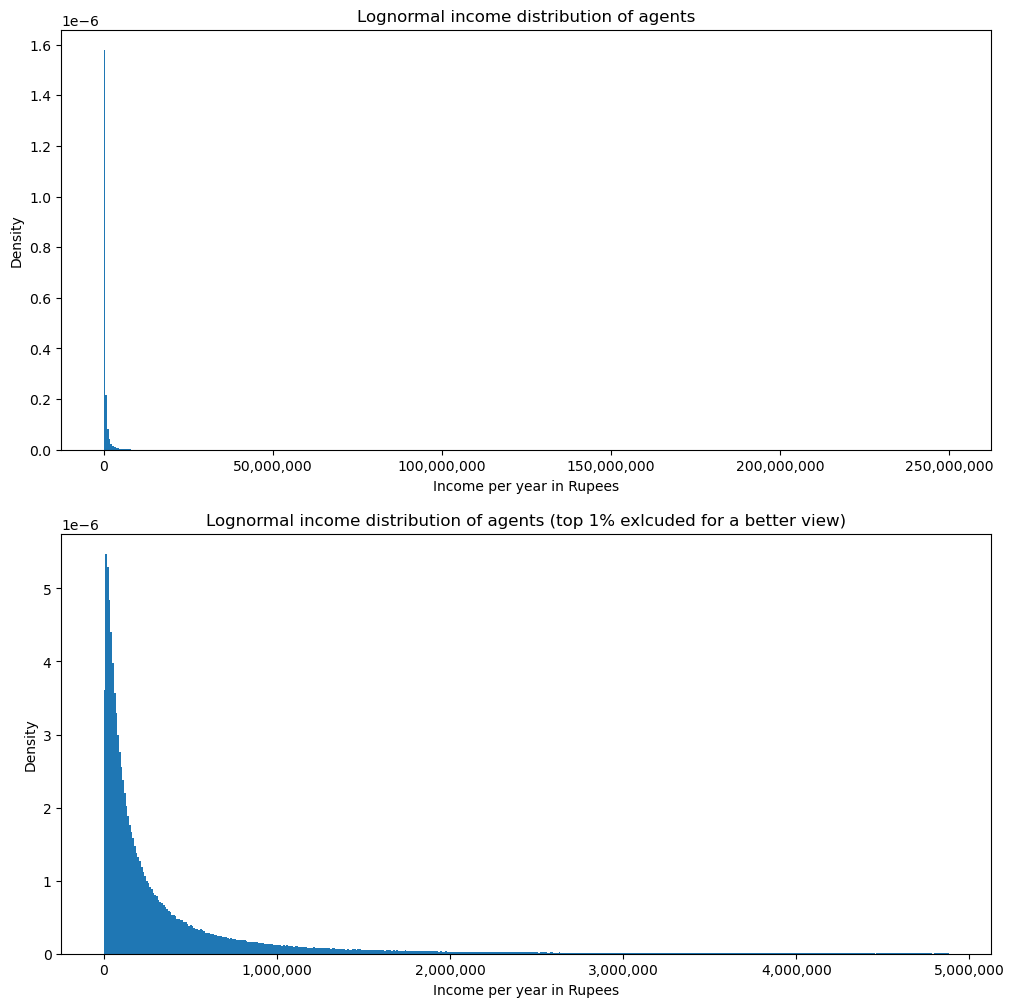

In [8]:
# plot the lognormal agents income distribution

n = 1_000_000
incomes, brackets, locations, neighborhoods = generate_agents(n)

# Cut off at, say, the 99.99th percentile for visualization
cutoff = np.percentile(incomes, 99.0)
incomes_percentile = incomes[incomes <= cutoff]

fig, axes = plt.subplots(2,1,figsize = (12,12)) # one plot for actual income distr, one with top 1% cut off, one with income brackets
# full distribution
axes[0].hist(incomes, bins = 500, density = True)
axes[0].set_title("Lognormal income distribution of agents")
axes[0].set_xlabel("Income per year in Rupees")
axes[0].set_ylabel("Density")
# format x-axis numbers with commas
axes[0].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# with top 1% cut off
axes[1].hist(incomes_percentile, bins = 500, density = True)
axes[1].set_title("Lognormal income distribution of agents (top 1% exlcuded for a better view)")
axes[1].set_xlabel("Income per year in Rupees")
axes[1].set_ylabel("Density")
axes[1].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [10]:
print(neighborhood_lists(neighborhoods))

[array([   153,    224,    317, ..., 999850, 999858, 999863]), array([    94,    231,    450, ..., 999854, 999953, 999996]), array([   104,    177,    265, ..., 999813, 999840, 999998]), array([    21,     36,    245, ..., 999912, 999959, 999976]), array([    73,     84,     87, ..., 999833, 999860, 999904]), array([    92,    100,    244, ..., 999883, 999922, 999954]), array([    18,    101,    147, ..., 999627, 999690, 999938]), array([    38,    348,    565, ..., 999873, 999962, 999968]), array([    13,     47,    183, ..., 999478, 999830, 999880]), array([    26,    125,    312, ..., 999671, 999895, 999991]), array([   175,    443,    461, ..., 999710, 999907, 999980]), array([    16,     88,    169, ..., 999702, 999783, 999808]), array([    10,    368,    413, ..., 999800, 999909, 999961]), array([    98,    341,    654, ..., 999714, 999779, 999804]), array([    15,    256,    493, ..., 999705, 999784, 999811]), array([     0,      1,     27, ..., 999437, 999483, 999736]), array([